# `CLOUD.jl` - 1D linear advection-diffusion example

In [1]:
using CLOUD, OrdinaryDiffEq, Plots

Define the physical problem

In [2]:
a = 1.0  # wave speed
b = 5.0e-2 # diffusion coefficient
L = 1.0  # domain length
T = 1.0  # end time for one period

initial_data = InitialDataSine(1.0,2π)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data);

Set discretization parameters

In [3]:
M = 4
p = 5
form = WeakConservationForm()
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.05*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*100));

Set up a `DGSEM` scheme with LGL quadrature of degree `p` with `M` elements

In [4]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Line(), volume_quadrature_rule=LGLQuadrature())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_diffusion_1d_dgsem/", overwrite=true, clear=true);

Run the solver and print timer outputs

In [5]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)
CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            463ms / 228.4%           57.6MiB / 567.6%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 auxiliary variable     17.6k    607ms   57.5%  34.4μs    194MiB   59.5%  11.3KiB
   apply operators      17.6k    466ms   44.2%  26.5μs    144MiB   44.0%  8.35KiB
     facet terms        17.6k    250ms   23.7%  14.2μs   72.2MiB   22.1%  4.20KiB
     volume terms       17.6k    117ms   11.1%  6.65μs   47.2MiB   14.4%  2.74KiB
     mass matrix solve  17.6k   8.93ms    0.8%   507ns   5.65MiB    1.7%     336B
   eval solution        17.6k    113ms   10.7%  6.39μs   37.5MiB   11.5%  2.18KiB
   eval num tra

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [6]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
1.4856115459914242e-6
Conservation (initial/final/diff):
[-1.6653345369377348e-16][-1.1796119636642288e-16][4.85722573273506e-17]
Energy (initial/final/diff):
[0.24999999999999986][0.0048240758685416][-0.24517592413145825]


Plot the exact and numerical solutions

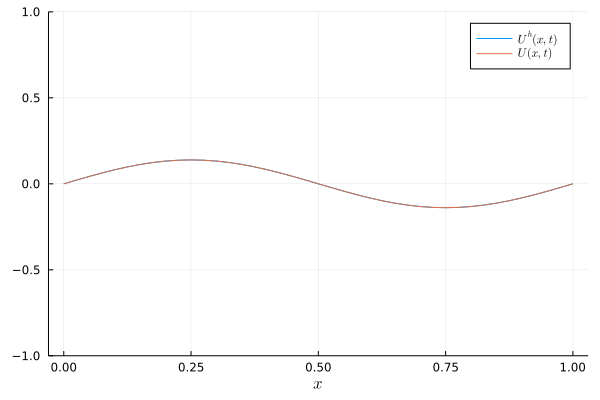

In [7]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[-1.0,1.0])

Animate the numerical solution

Plots.AnimatedGif("/Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif")
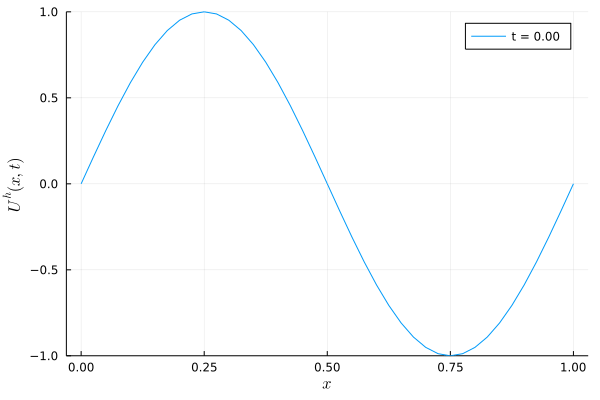

In [8]:
using Printf
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("t = ", @sprintf "%.2f" sol.t[i]))
end
gif(anim, "advection_diffusion_solution.gif", fps = 10)